Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import cv2
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import  Dense, Input,InputLayer, Dropout, Flatten,Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
import seaborn as sns

In [2]:
#This is done using google drive create folders in your directory accordingly
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [9]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('gdrive/My Drive/Cancer/Train')
data_dir_test = pathlib.Path('gdrive/My Drive/Cancer/Test')

In [10]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [33]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,image_size=(180,180),batch_size=32,
                                                             seed=123,validation_split=0.2,subset='training'#,label_mode='categorical'
                                                             )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [34]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,image_size=(180,180),batch_size=32,
                                                             seed=123,validation_split=0.2,subset='validation'#,label_mode='categorical'
                                                             )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [13]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

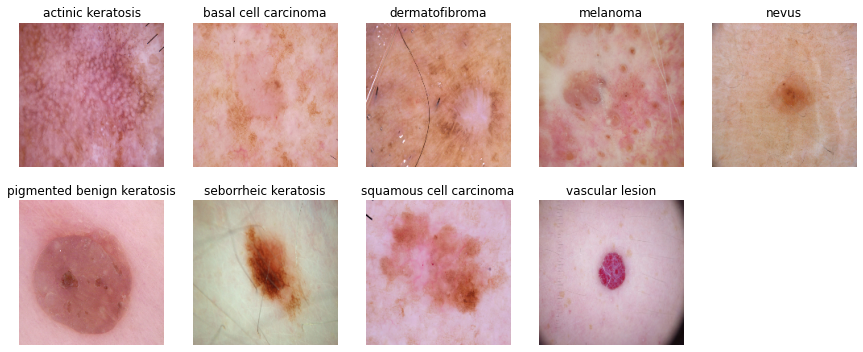

In [14]:
#visualizing dataset each from each class

for img,label in train_ds.take(5):
    images = img.numpy()
    labels = label.numpy()
    if len(np.unique(labels))==9:break
fig = plt.figure(figsize=(15,6))
for i in range(9):
    ax = fig.add_subplot(2, 5, 1 + i)
    idx = np.where(labels[:]==i)[0][0]
    im = images[idx]/255
    ax.set_title(class_names[i])
    plt.imshow(im)
    plt.axis('off')
plt.show()   

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [35]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [36]:
#Normalizing the pixel values
norm_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (norm_layer(x), y))
val_ds = val_ds.map(lambda x, y: (norm_layer(x), y))
image_train, labels_train = next(iter(train_ds))
image_val, labels_val = next(iter(val_ds))
print(np.min(image_train[0]), np.max(image_train[0]))
print(np.min(image_val[0]), np.max(image_val[0]))


0.17173237 0.9563732
0.014221026 0.99915177


In [18]:
#Creating model
model = Sequential()

num_classes=9#No of classes
input_shape=(180,180,3)#Input image shape

model.add(Conv2D(128, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=input_shape,padding='SAME'))#Convolutional layer
model.add(MaxPooling2D(pool_size=(2, 2))) #Maxpool layers
#model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding='SAME'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128,activation='relu'))

# softmax layer for multiclassification
model.add(Dense(num_classes, activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [19]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 1036800)           0         
_________________________________________________________________
dense (Dense)                (None, 128)               132710528 
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1161      
Total params: 132,715,273
Trainable params: 132,715,273
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,verbose=1
)

Epoch 1/20
56/56 [==============================] - 42s 639ms/step - loss: 2.0741 - accuracy: 0.2118 - val_loss: 2.0023 - val_accuracy: 0.3154
Epoch 2/20
56/56 [==============================] - 4s 78ms/step - loss: 1.9758 - accuracy: 0.2729 - val_loss: 1.9702 - val_accuracy: 0.2595
Epoch 3/20
56/56 [==============================] - 4s 80ms/step - loss: 1.8884 - accuracy: 0.3039 - val_loss: 1.8757 - val_accuracy: 0.2931
Epoch 4/20
56/56 [==============================] - 4s 79ms/step - loss: 1.8401 - accuracy: 0.3424 - val_loss: 1.8055 - val_accuracy: 0.3647
Epoch 5/20
56/56 [==============================] - 4s 78ms/step - loss: 1.8125 - accuracy: 0.3572 - val_loss: 1.7954 - val_accuracy: 0.3445
Epoch 6/20
56/56 [==============================] - 4s 78ms/step - loss: 1.7946 - accuracy: 0.3493 - val_loss: 1.7998 - val_accuracy: 0.3736
Epoch 7/20
56/56 [==============================] - 4s 78ms/step - loss: 1.7634 - accuracy: 0.3825 - val_loss: 1.7885 - val_accuracy: 0.3490
Epoch 8/20


### Visualizing training results

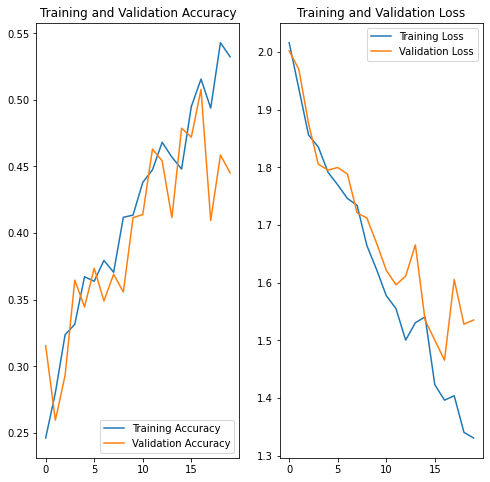

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### We can see the model has accuracy of arround 45-50% which is low. There is also overfitting appearing around last few epochs It might be because less data. We will perform data augmentation and check if help us or not

In [49]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

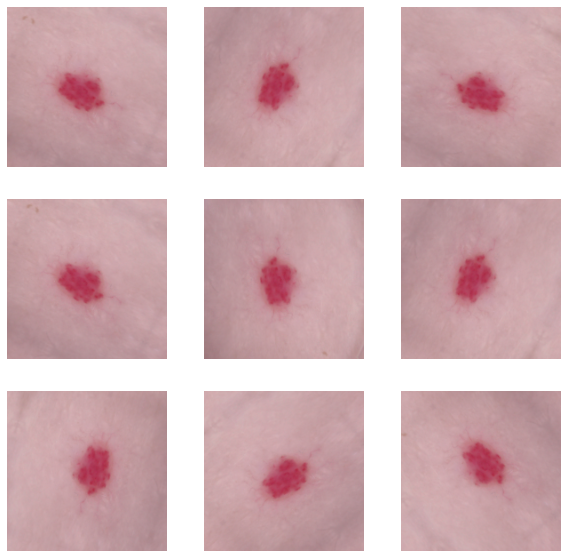

In [52]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
# Add the image to a batch
image = tf.expand_dims(image_train[0], 0)
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [60]:
tf.keras.backend.clear_session()

In [67]:
model2=Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal',input_shape=input_shape),
    layers.experimental.preprocessing.RandomRotation(0.1)
])

# a keras convolutional layer is called Conv2D
# help(Conv2D)
# note that the first layer needs to be told the input shape explicitly
num_classes=9
input_shape=(180,180,3)
# first conv layer
model2.add(Conv2D(64, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=input_shape,padding='SAME'))
model2.add(MaxPooling2D(pool_size=(2, 2))) 
model2.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding='SAME'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(16, kernel_size=(3, 3),activation='relu',padding='SAME'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(16, kernel_size=(3, 3),activation='relu',padding='SAME'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flatten and put a fully connected layer
model2.add(Flatten())
model2.add(Dense(64,activation='relu'))
#model2.add(Dense(64, activation='relu'))

#model.add(Dropout(0.25))

# softmax layer
model2.add(Dense(num_classes, activation='softmax'))

# model summary
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_4 (RandomFlip)   (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation_4 (RandomRot (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 180, 180, 64)      1792      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 90, 90, 32)        18464     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 45, 45, 16)       

### Compiling the model

In [68]:
## Your code goes here
model2.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'],)


### Training the model

In [69]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history1 = model2.fit(train_ds,epochs=epochs,validation_data=val_ds)

Epoch 1/20
56/56 [==============================] - 3s 46ms/step - loss: 2.0749 - accuracy: 0.2043 - val_loss: 1.9428 - val_accuracy: 0.3445
Epoch 2/20
56/56 [==============================] - 2s 43ms/step - loss: 1.8988 - accuracy: 0.3034 - val_loss: 1.7702 - val_accuracy: 0.3848
Epoch 3/20
56/56 [==============================] - 2s 43ms/step - loss: 1.6781 - accuracy: 0.3863 - val_loss: 1.5787 - val_accuracy: 0.4564
Epoch 4/20
56/56 [==============================] - 2s 43ms/step - loss: 1.5734 - accuracy: 0.4439 - val_loss: 1.5646 - val_accuracy: 0.4877
Epoch 5/20
56/56 [==============================] - 2s 44ms/step - loss: 1.4976 - accuracy: 0.4763 - val_loss: 1.5124 - val_accuracy: 0.4922
Epoch 6/20
56/56 [==============================] - 3s 46ms/step - loss: 1.4683 - accuracy: 0.4854 - val_loss: 1.4231 - val_accuracy: 0.5078
Epoch 7/20
56/56 [==============================] - 2s 43ms/step - loss: 1.4226 - accuracy: 0.4908 - val_loss: 1.4927 - val_accuracy: 0.5123
Epoch 8/20
56

### Visualizing the results

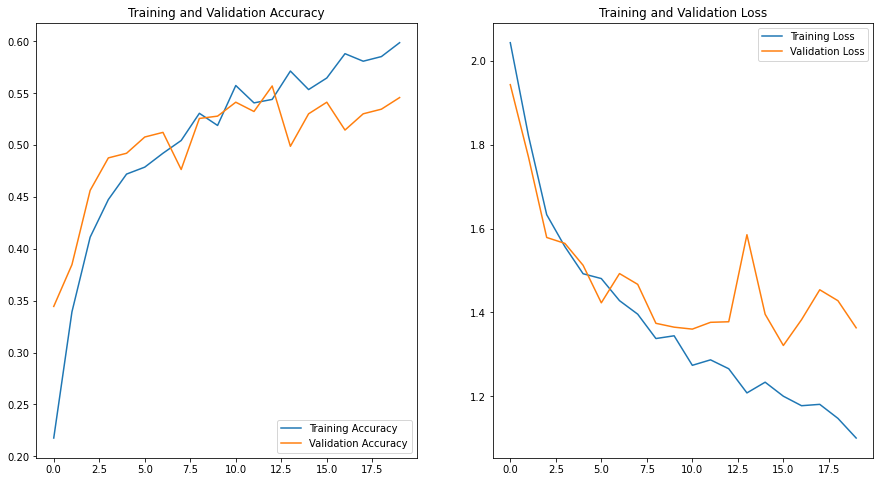

In [70]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The accuracy has improve a bit to 55% and there is lesser overfitting.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [72]:
data_dir_train1 = pathlib.Path('gdrive/My Drive/Cancer/Train')
data_dir_train = pathlib.Path('gdrive/My Drive/Cancer/Train')
image_count_train = len(list(data_dir_train.glob('*//*.jpg')))
print(image_count_train)
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df= pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

2239


In [73]:
#definition to visualize distribution among classes
def class_dist(df):
  tot=df['Label'].value_counts().sum()
  ax = round(df['Label'].value_counts()*100/tot,1).plot.bar()
  for p in ax.patches:
      ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.009))

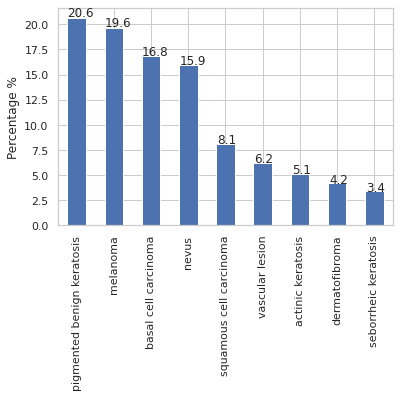

In [76]:
sns.set_theme(style="whitegrid")
class_dist(original_df)
plt.ylabel('Percentage %')
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### seborrheic keratosis has the least no. of sample 

#### - Which classes dominate the data in terms proportionate number of samples?
#### pigmented benign keratosis with 20% of whole datase


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [77]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [78]:
path_to_training_dataset="gdrive/My Drive/Cancer/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/Cancer/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F02C20C0978>: 100%|██████████| 500/500 [00:18<00:00, 27.30 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F02C6990320>:   0%|          | 1/500 [00:00<00:56,  8.76 Samples/s]

Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/Cancer/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F02C20FA2E8>: 100%|██████████| 500/500 [00:19<00:00, 26.25 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/Cancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F02C205D828>: 100%|██████████| 500/500 [00:18<00:00, 26.65 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/Cancer/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F02C698D7F0>: 100%|██████████| 500/500 [01:27<00:00,  5.69 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/Cancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=962x676 at 0x7F02C2077240>: 100%|██████████| 500/500 [01:13<00:00,  6.78 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/Cancer/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F02CA884048>: 100%|██████████| 500/500 [00:18<00:00, 26.75 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/Cancer/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F02C20FB7F0>: 100%|██████████| 500/500 [00:40<00:00, 12.42 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/Cancer/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F02C69809B0>: 100%|██████████| 500/500 [00:18<00:00, 26.83 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F02C20FB470>:   0%|          | 1/500 [00:00<01:04,  7.71 Samples/s]

Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/Cancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F046BB6F7B8>: 100%|██████████| 500/500 [00:18<00:00, 26.44 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [79]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [81]:
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['gdrive/My Drive/Cancer/Train/actinic keratosis/ISIC_0028517.jpg',
 'gdrive/My Drive/Cancer/Train/actinic keratosis/ISIC_0027452.jpg',
 'gdrive/My Drive/Cancer/Train/actinic keratosis/ISIC_0030491.jpg',
 'gdrive/My Drive/Cancer/Train/actinic keratosis/ISIC_0026194.jpg',
 'gdrive/My Drive/Cancer/Train/actinic keratosis/ISIC_0026709.jpg',
 'gdrive/My Drive/Cancer/Train/actinic keratosis/ISIC_0030133.jpg',
 'gdrive/My Drive/Cancer/Train/actinic keratosis/ISIC_0029025.jpg',
 'gdrive/My Drive/Cancer/Train/actinic keratosis/ISIC_0028063.jpg',
 'gdrive/My Drive/Cancer/Train/actinic keratosis/ISIC_0027668.jpg',
 'gdrive/My Drive/Cancer/Train/actinic keratosis/ISIC_0025803.jpg',
 'gdrive/My Drive/Cancer/Train/actinic keratosis/ISIC_0026149.jpg',
 'gdrive/My Drive/Cancer/Train/actinic keratosis/ISIC_0028820.jpg',
 'gdrive/My Drive/Cancer/Train/actinic keratosis/ISIC_0029041.jpg',
 'gdrive/My Drive/Cancer/Train/actinic keratosis/ISIC_0025825.jpg',
 'gdrive/My Drive/Cancer/Train/actinic keratosis

In [82]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [83]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [84]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [85]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

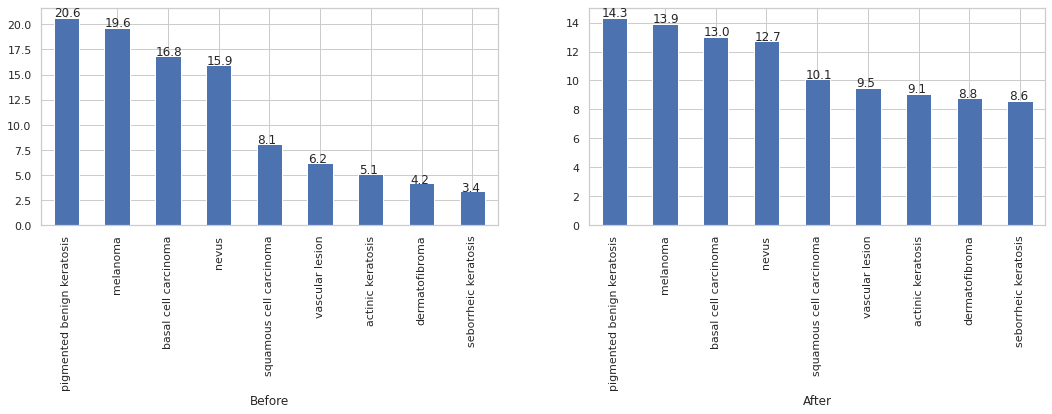

In [86]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
class_dist(original_df)
plt.xlabel('Before')
plt.subplot(1,2,2)
class_dist(new_df)
plt.xlabel('After')
plt.show()

#### The classes are more balanced now

#### **Todo**: Train the model on the data created using Augmentor

In [87]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [88]:
data_dir_train='gdrive/My Drive/Cancer/Train'
train_ds_new = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [89]:
val_ds_new = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [90]:
## your code goes here
#Normalizing the pixel values
norm_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds_new = train_ds_new.map(lambda x, y: (norm_layer(x), y))
val_ds_new = val_ds_new.map(lambda x, y: (norm_layer(x), y))
image_train, labels_train = next(iter(train_ds_new))
image_val, labels_val = next(iter(val_ds_new))
print(np.min(image_train[0]), np.max(image_train[0]))
print(np.min(image_val[0]), np.max(image_val[0]))


0.25702775 0.9946083
0.051143948 0.99346334


In [91]:
model3=Sequential()

# a keras convolutional layer is called Conv2D
# help(Conv2D)
# note that the first layer needs to be told the input shape explicitly
num_classes=9
input_shape=(180,180,3)
# first conv layer
model3.add(Conv2D(64, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=input_shape,padding='SAME'))
#model3.add(Conv2D(128, kernel_size=(3, 3),activation='relu',padding='SAME'))
model3.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25))
model3.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding='SAME'))
#model3.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding='SAME'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model3.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding='SAME'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(16, kernel_size=(3, 3),activation='relu',padding='SAME'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model.add(BatchNormalization())
model.add(Dropout(0.25))

# flatten and put a fully connected layer
model3.add(Flatten())
#model3.add(Dense(32,activation='relu'))
model3.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

# softmax layer
model3.add(Dense(num_classes, activation='softmax'))

# model summary
model3.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 180, 180, 64)      1792      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 90, 90, 64)        36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 45, 45, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 22, 22, 16)       

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [92]:
model3.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#### **Todo:**  Train your model

In [93]:
## Your code goes here, use 50 epochs.
epochs=50
history2 = model3.fit(train_ds_new,batch_size=50,epochs=epochs,validation_data=val_ds_new,verbose=1)

Epoch 1/50
169/169 [==============================] - 45s 255ms/step - loss: 2.1475 - accuracy: 0.1650 - val_loss: 1.6166 - val_accuracy: 0.4016
Epoch 2/50
169/169 [==============================] - 45s 259ms/step - loss: 1.5469 - accuracy: 0.4202 - val_loss: 1.4080 - val_accuracy: 0.4402
Epoch 3/50
169/169 [==============================] - 45s 260ms/step - loss: 1.3495 - accuracy: 0.4677 - val_loss: 1.3264 - val_accuracy: 0.4996
Epoch 4/50
169/169 [==============================] - 45s 259ms/step - loss: 1.2801 - accuracy: 0.5024 - val_loss: 1.2382 - val_accuracy: 0.5152
Epoch 5/50
169/169 [==============================] - 45s 257ms/step - loss: 1.1521 - accuracy: 0.5561 - val_loss: 1.1979 - val_accuracy: 0.5442
Epoch 6/50
169/169 [==============================] - 44s 255ms/step - loss: 1.0567 - accuracy: 0.6085 - val_loss: 1.1327 - val_accuracy: 0.5805
Epoch 7/50
169/169 [==============================] - 44s 251ms/step - loss: 0.9852 - accuracy: 0.6360 - val_loss: 1.0338 - val_ac

#### **Todo:**  Visualize the model results

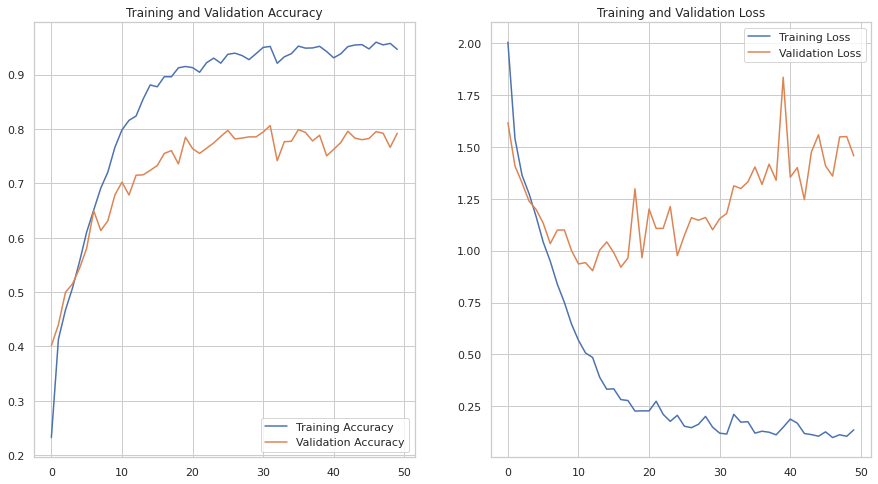

In [94]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



###Class rebalance has helped in increasing the model accuracy significantly upto 80%. But there is still some overfitting which can be removed by increasing dropouts.